# 陈天奇的  XGBoost


In [ ]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime

from xgboost import XGBClassifier 


## 回归

In [ ]:
#xgb实现法
import xgboost as xgb


data = load_boston()
X = data.data
y = data.target

Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.1,random_state=420)

#使用类DMatrix读取数据
dtrain = xgb.DMatrix( Xtrain,Ytrain ) #特征矩阵和标签都进行一个传入
dtest = xgb.DMatrix( Xtest,Ytest )



In [ ]:
X.shape

In [ ]:

import pandas as pd

pd.DataFrame(Xtrain)


In [ ]:
#写明参数
param = {
          'objective':'reg:squarederror'
         ,"eta":0.1}
num_round = 250 #n_estimators

#类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train(param, dtrain, num_round)

#接口predict
preds = bst.predict(dtest)

MSE(Ytest,preds)


## 多分类

In [ ]:
def loadData( fileName, n=1000):
        '''
        加载文件

        :param fileName:要加载的文件路径
        :param n: 返回的数据集的规模
        :return: 数据集和标签集
        '''
        # 存放数据及标记
        dataArr = []
        labelArr = []
        # 读取文件
        fr = open(fileName)

        cnt = 0  # 计数器

        # 遍历文件中的每一行
        for line in fr.readlines():


            if cnt == n:
                break

            # 获取当前行，并按“，”切割成字段放入列表中
            # strip：去掉每行字符串首尾指定的字符（默认空格或换行符）
            # split：按照指定的字符将字符串切割成每个字段，返回列表形式
            curLine = line.strip().split(',')
            # 将每行中除标记外的数据放入数据集中（curLine[0]为标记信息）
            # 在放入的同时将原先字符串形式的数据转换为整型
            # 此外将数据进行了二值化处理，大于128的转换成1，小于的转换成0，方便后续计算
            dataArr.append([int(int(num) > 128) for num in curLine[1:]])

            # 将标记信息放入标记集中
            labelArr.append(int(curLine[0]))
            cnt += 1

        fr.close()

        # 返回数据集和标记
        return dataArr, labelArr

    
    


### sklearn 的 xgboost 接口

In [ ]:
n_train=60000
n_test=10000

# 获取训练集
trainDataList, trainLabelList = loadData('../Mnist/mnist_train.csv', n=n_train)

print('train data, row num:{} , column num:{} '.format(len(trainDataList), len(trainDataList[0])))

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)

# 开始时间
print('start training model....')
start = time.time()


"""

XGBClassifier 测试1:
max_depth=3, n_estimators=20, learning_rate=0.5, 
n_train=60000
n_test=10000
训练时间 : 38 s
准确率: 0.9155

"""


clf = XGBClassifier(
    max_depth=3, #
    learning_rate=0.5, # 学习率 eta 
    n_estimators=20, # 使用多少个弱分类器
    
    eval_metric='mlogloss',
    
    num_class=10,
   
    gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
    min_child_weight=1,
    max_delta_step=0,
    subsample=1, # 随机抽样的时候抽取的样本比例, 范围 (0,1]
    colsample_bytree=1,
    reg_alpha=0, # L1 正则化的强度
    reg_lambda=1, # L2 正则化的强度
    use_label_encoder=False
)

clf.fit(trainDataArr, trainLabelArr)


# 结束时间
end = time.time()
print('training cost time :', end - start)

# 获取测试集
testDataList, testLabelList = loadData('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)

print('test dataset accuracy: {} '.format(clf.score(testDataArr, testLabelArr)))

#### 学习曲线

In [ ]:
n_train=6000
n_test=1000

# 获取训练集
trainDataList, trainLabelList = loadData('../Mnist/mnist_train.csv', n=n_train)

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)

Xtrain,Ytrain = trainDataArr, trainLabelArr 


# 获取测试集
testDataList, testLabelList = loadData('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)

Xtest,Ytest = testDataArr, testLabelArr 



In [ ]:
def plot_learning_curve(estimator,title, X, y, 
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            ,random_state=420
                                                            ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax


In [ ]:
clf = XGBClassifier(
    max_depth=3, #
    learning_rate=0.5, # 学习率 eta 
    n_estimators=20, # 使用多少个弱分类器
    
    eval_metric='mlogloss',
    
    num_class=10,
   
    gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
    min_child_weight=1,
    max_delta_step=0,
    subsample=1, # 随机抽样的时候抽取的样本比例, 范围 (0,1]
    colsample_bytree=1,
    reg_alpha=0, # L1 正则化的强度
    reg_lambda=1, # L2 正则化的强度
    use_label_encoder=False
)

plot_learning_curve(clf
                    ,"XGBoost",Xtrain,Ytrain,ax=None,cv=5)
plt.show()

#### 参数调优 - 交叉验证

In [ ]:
%%time 

# 超参数 n_estimators 调优
#=====【TIME WARNING： 6min 】=====#

axisx = range(10,100,10)
rs = []
for i in axisx:
    
    clf = XGBClassifier(
        max_depth=3, #
        learning_rate=0.5, # 学习率 eta 
        n_estimators=i, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        min_child_weight=1,
        max_delta_step=0,
        subsample=1, # 有放回的随机抽样 的时候抽取的样本比例, 范围 (0,1]
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )
    
    rs.append( CVS( clf , Xtrain, Ytrain, cv=5 , n_jobs=-1).mean() ) #  n_jobs=-1 开启所有的 CPU 核
    
print( axisx[rs.index(max(rs))], max(rs) ) # n_estimators=90   accuracy= 0.932

plt.figure(figsize=(20,5))
plt.plot( axisx,rs,c="red",label="XGBoost" )
plt.legend()
plt.show()

In [ ]:
%%time 

# 超参数 learning_rate 调优
#=====【TIME WARNING：12min  】=====#


axisx = np.linspace(0.1,1,10)
rs = []
for i in axisx:
    
    clf = XGBClassifier(
        max_depth=3, #
        learning_rate=i, # 学习率 eta 
        n_estimators=90, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        min_child_weight=1,
        max_delta_step=0,
        subsample=1, # 有放回的随机抽样 的时候抽取的样本比例, 范围 (0,1]
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )
    
    rs.append( CVS( clf,Xtrain,Ytrain,cv=5 ).mean() ) # 
    
    
print( "best param:{} , score:{}".format( axisx[rs.index(max(rs))], max(rs) )) # learning_rate=0.4 accuracy=0.9335000000000001

plt.figure(figsize=(20,5))
plt.plot( axisx,rs,c="red",label="XGBoost" )
plt.legend()
plt.show()

In [ ]:
%%time 

# 超参数 subsample 调优

#=====【TIME WARNING：9 min 】=====#



#首先我们先来定义一个评分函数，这个评分函数能够帮助我们直接打印Xtrain上的交叉验证结果
def clfassess(clf,Xtrain,Ytrain,scoring = ["accuracy"],show=True):
    
    score = []
    for i in range(len(scoring)):
        
        c=CVS (clf,Xtrain,Ytrain,cv=5,scoring=scoring[i]).mean()
        
        if show:
            print("{}:{:.2f}".format(scoring[i] #模型评估指标的名字
                                ,c))
            
        score.append((c).mean())
        
    return score

axisx = np.linspace(0.5,1,5)
rs = []
te = []
for i in axisx:
    
    clf = XGBClassifier(
        
        max_depth=3, #
        learning_rate=0.4, # 学习率 eta 
        n_estimators=90, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        min_child_weight=1,
        max_delta_step=0,
        
        subsample=i, # 有放回的随机抽样 的时候抽取的样本比例, 范围 (0,1]
        
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )
    
    score = clfassess( clf, Xtrain, Ytrain, scoring = ["accuracy"], show=True)
    
    test = clf.fit( Xtrain,Ytrain ).score( Xtest, Ytest )
    
    rs.append(score[0])
    te.append(test)
    
     
print("best param:{} , score:{}".format(axisx[rs.index(max(rs))],max(rs))) # subsample=0.625 accuracy=0.9338

plt.figure(figsize=(20,5))

plt.plot(axisx,te,c="gray",label="test")
plt.plot(axisx,rs,c="green",label="train")
plt.legend()
plt.show()


In [ ]:
# 查看测试集 上的混淆矩阵

from sklearn.metrics import confusion_matrix 

from sklearn.utils.class_weight import compute_sample_weight


y_pred= clf.predict( testDataArr )
y_true=testLabelArr


confusion_matrix(y_true, y_pred) # 

sw = compute_sample_weight(class_weight='balanced',y=y_true)

confusion_matrix(y_true, y_pred, sample_weight=sw)


#### 参数调优 - 网格搜索

In [ ]:
#来查看一下sklearn中所有的 模型评估指标
import sklearn
sorted(sklearn.metrics.SCORERS.keys())


ref:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
from sklearn.model_selection import GridSearchCV


def print_best_score(gsearch,param_test):
     # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

        


In [ ]:

param = {
    'gamma':  [0,2,5],
    'max_depth': range(1,5,1)
}
#网格搜索 是 两个 参数集合的全组合(笛卡尔积), 因此 集合中的元素个数 不宜过多

estimator = XGBClassifier(
        
        max_depth=3, #
        learning_rate=0.4, # 学习率 eta 
        n_estimators=90, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        
        min_child_weight=1,
        max_delta_step=0,
        
        subsample=0.625, # 有放回的随机抽样, 抽取的样本比例, 范围 (0,1]
        
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )

gsearch = GridSearchCV( estimator , param_grid = param, scoring='accuracy', cv=5 , n_jobs=-1 )

gsearch.fit( Xtrain,Ytrain )


print_best_score(gsearch,param)

# Best score: 0.937
# Best parameters set:
# 	gamma: 0
# 	max_depth: 4


## 二分类

### xgboost 原生接口

In [ ]:

def loadData_2classification( fileName, n=1000):
    '''
    加载文件

    将 数据集 的标签 转换为 二分类的标签

    :param fileName:要加载的文件路径
    :param n: 返回的数据集的规模
    :return: 数据集和标签集
    '''
    # 存放数据及标记
    dataArr = []
    labelArr = []
    # 读取文件
    fr = open(fileName)

    cnt = 0  # 计数器

    # 遍历文件中的每一行
    for line in fr.readlines():

        if cnt == n:
            break

        # 获取当前行，并按“，”切割成字段放入列表中
        # strip：去掉每行字符串首尾指定的字符（默认空格或换行符）
        # split：按照指定的字符将字符串切割成每个字段，返回列表形式
        curLine = line.strip().split(',')
        # 将每行中除标记外的数据放入数据集中（curLine[0]为标记信息）
        # 在放入的同时将原先字符串形式的数据转换为整型
        # 此外将数据进行了二值化处理，大于128的转换成1，小于的转换成0，方便后续计算
        dataArr.append([int(int(num) > 128) for num in curLine[1:]])

        # 将标记信息放入标记集中
        # 转换成二分类任务
        # 标签0设置为1，反之为0

        # 显然这会导致 正负 样本的 分布不均衡, 1 的样本很少(10%), 而0 的很多
        if int(curLine[0]) == 0:
            labelArr.append(1)
        else:
            labelArr.append(0)

        # if int(curLine[0]) <= 5:
        #     labelArr.append(1)
        # else:
        #     labelArr.append(0)

        cnt += 1

    fr.close()

    # 返回数据集和标记
    return dataArr, labelArr
    
    



In [ ]:
n_train=6000

# 获取训练集
trainDataList, trainLabelList =loadData_2classification('../Mnist/mnist_train.csv', n=n_train)

print('train data, row num:{} , column num:{} '.format(len(trainDataList), len(trainDataList[0])))

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)


n_test=1000

# 获取测试集
testDataList, testLabelList = loadData_2classification('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)


In [ ]:

import xgboost as xgb


#使用类DMatrix读取数据
dtrain = xgb.DMatrix( trainDataArr,trainLabelArr ) #特征矩阵和标签都进行一个传入
dtest = xgb.DMatrix( testDataArr,testLabelArr )


In [ ]:
# 使用 pandas 查看样本

import pandas as pd

pd.DataFrame(trainDataArr)

In [ ]:
# estimator = XGBClassifier(
        
#         max_depth=3, #
#         learning_rate=0.4, # 学习率 eta 
#         n_estimators=90, # 使用多少个弱分类器
#         eval_metric='mlogloss',
#         num_class=10,
#         gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
#         min_child_weight=1,
#         max_delta_step=0,
#         subsample=0.625, # 有放回的随机抽样, 抽取的样本比例, 范围 (0,1]
#         colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
#         reg_alpha=0, # L1 正则化的强度
#         reg_lambda=1, # L2 正则化的强度
#         use_label_encoder=False
#     )


# param= {'silent':True,'objective':'binary:logistic',"eta":0.4}

param= {'eval_metric':'logloss',"eta":0.4,}


num_round = 90 #n_estimators

#类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train( param, dtrain, num_round )


In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score

from sklearn.metrics import recall_score

from sklearn.metrics import f1_score


y_pred =( bst.predict(dtest) > 0.5 ).astype(int) #  predict() 返回的是概率  

y_true= testLabelArr

# 1.正确率
print('test dataset accuracy: {} '.format(accuracy_score(y_true, y_pred)))

print('====================')

#### 样本不均衡问题



In [ ]:

print( '0 负样本所占的比例: {} '.format( len(trainLabelArr[trainLabelArr==0])/len(trainLabelArr) ))  



In [ ]:
from sklearn.metrics import confusion_matrix as cm, accuracy_score as accuracy ,recall_score as recall, roc_auc_score as auc


#写明参数
scale_pos_weight = [ 0.5 , 1 , 5 , 9 ,10]
names = [
    
         "negative vs positive: 0.5 ",
         "negative vs positive: 1",
         "negative vs positive: 5",
         "negative vs positive: 9",
         "negative vs positive: 10"
        
        ]


[*zip(names,scale_pos_weight)]


for name,i in zip(names,scale_pos_weight):
    
    param= { 'eval_metric':'logloss',"eta":0.4,"scale_pos_weight":i } # scale_pos_weight = 负样本 / 正样本
    
    num_round = 40
    
    clf = xgb.train(param, dtrain, num_round)
    
    preds = clf.predict(dtest)
    
    ypred = preds.copy()
    ypred[preds > 0.5] = 1
    ypred[ypred != 1] = 0
    
    print(name)
    
    print("\tAccuracy:{}".format(accuracy(testLabelArr,ypred)))
    print("\tRecall:{}".format(recall(testLabelArr,ypred)))
    print("\tAUC:{}".format(auc(testLabelArr,preds)))


#### 交叉验证

In [ ]:
#设定参数
param1 = { 'eval_metric':'logloss',"eta":0.4,"scale_pos_weight":9 , "gamma":0 }
param2 = { 'eval_metric':'logloss',"eta":0.4,"scale_pos_weight":9 , "gamma":5 }

num_round = 40
n_fold=5 # sklearn - KFold


cvresult1 = xgb.cv(param1, dtrain, num_round ,n_fold ,  metrics='auc')


cvresult2 = xgb.cv(param2, dtrain, num_round ,n_fold ,  metrics='auc')

plt.figure(figsize=(20,5))
plt.grid()

plt.plot(range(1,41),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,41),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.plot(range(1,41),cvresult2.iloc[:,0],c="green",label="train,gamma=5")
plt.plot(range(1,41),cvresult2.iloc[:,2],c="blue",label="test,gamma=5")

plt.legend()
plt.show()


In [ ]:
#看看类xgb.cv生成了什么结果？

cvresult1 


### Higgs 数据集


下载数据集


原始 Higgs 数据集
ref:
https://archive.ics.uci.edu/ml/datasets/HIGGS

总记录数
11000000


论文中使用的大小
Higgs 10M( million = 百万) dataset


kaggle 竞赛数据集 
ref:https://www.kaggle.com/c/higgs-boson/data

总记录数
550000


In [ ]:
import pandas as pd

Higgs_dataset_path= '../dataset/higgs/kaggle'


# 取前10 行 看看长啥样子
data = pd.read_csv(Higgs_dataset_path+'/training.csv',skiprows=0,nrows =10 )

data.shape
data # 


In [ ]:
# load in training data, directly use numpy
dtrain = np.loadtxt(Higgs_dataset_path+'/training.csv' , delimiter=',', skiprows=1, converters={32: lambda x:int(x=='s'.encode('utf-8')) } )

# converters 对最后一列进行转换

print ('finish loading from csv ')

In [ ]:
dtrain.shape

In [ ]:
label  = dtrain[:,32]
data   = dtrain[:,1:31]

test_size = 550000

# rescale weight to make it same as test set
weight = dtrain[:,31] * float(test_size) / len(label)

sum_wpos = sum( weight[i] for i in range(len(label)) if label[i] == 1.0  )
sum_wneg = sum( weight[i] for i in range(len(label)) if label[i] == 0.0  )

# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
xgmat = xgb.DMatrix( data, label=label, missing = -999.0, weight=weight )

# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'binary:logitraw'
# scale weight of positive examples
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.1
param['max_depth'] = 6
param['eval_metric'] = 'auc'
param['nthread'] = 16

# you can directly throw param in, though we want to watch multiple metrics here
plst = list(param.items())+[('eval_metric', 'ams@0.15')] # 

watchlist = [ (xgmat,'train') ]
# boost 120 trees
num_round = 120
print ('loading data end, start to boost trees')
bst = xgb.train( plst, xgmat, num_round, watchlist );
# save out model
bst.save_model('higgs.model')

print ('finish training')

**watchlist 使用** 

作用: 在训练的时候 查看模型的训练效果

划分20%为验证集 (dval)，准备一个watchlist 给train和validation set ,这样我们能发现每一个round 的验证集预测结果，如果在某一个round后 validation set 的预测误差上升了，你就可以停止掉正在运行的程序了( early stop )。

训练效果的 评价指标 通过参数 'eval_metric' 控制

eg.

In [ ]:
param['eval_metric'] = 'auc'

watchlist = [(dtrain,'train'),(dval,'val')]

model = xgb.train(params,dtrain,num_boost_round=100,evals = watchlist)

In [ ]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('higgs.model')

In [ ]:
# 取前10 行 看看长啥样子
data = pd.read_csv(Higgs_dataset_path+'/test.csv',skiprows=0,nrows =10 )

data.shape # 发现测试数据集 没有标签列, 模型预测完测试集后提交到 kaggle 平台验证
data # 

In [ ]:
### load data in do training
train = np.loadtxt(Higgs_dataset_path+'/training.csv', delimiter=',', skiprows=1, converters={32: lambda x:int(x=='s'.encode('utf-8')) } )

label  = train[:,32]
data   = train[:,1:31]
weight = train[:,31]
dtrain = xgb.DMatrix( data, label=label, missing = -999.0, weight=weight )
param = {'max_depth':6, 'eta':0.1, 'objective':'binary:logitraw', 'nthread':4}
num_round = 120

print ('running cross validation, with preprocessing function')
# define the preprocessing function
# used to return the preprocessed training, test data, and parameter
# we can use this to do weight rescale, etc.
# as a example, we try to set scale_pos_weight
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label==1)
    param['scale_pos_weight'] = ratio
    wtrain = dtrain.get_weight()
    wtest = dtest.get_weight()
    sum_weight = sum(wtrain) + sum(wtest)
    wtrain *= sum_weight / sum(wtrain)
    wtest *= sum_weight / sum(wtest)
    dtrain.set_weight(wtrain)
    dtest.set_weight(wtest)
    return (dtrain, dtest, param)

# do cross validation, for each fold
# the dtrain, dtest, param will be passed into fpreproc
# then the return value of fpreproc will be used to generate
# results of that fold

xgb.cv(param, dtrain, num_round, nfold=5,metrics={'ams@0.15', 'auc'}, seed = 0, fpreproc = fpreproc)



### 近似算法

In [ ]:
#设定参数
param1 = { 'objective':'binary:logistic',"eta":0.1,"max_depth":6 , "nthread":16}
param2 = { 'objective':'binary:logistic',"eta":0.1,"max_depth":6 , "nthread":16, "tree_method": 'approx', "sketch_eps":0.3}

num_round = 90
n_fold=5 # sklearn - KFold

In [ ]:
%%time
cvresult1 = xgb.cv(param1, dtrain, num_round ,n_fold ,  metrics='auc')

# 2min 18s

In [ ]:
%%time
cvresult2 = xgb.cv(param2, dtrain, num_round ,n_fold ,  metrics='auc')

# 1min 25s

In [ ]:
plt.figure(figsize=(20,5))

plt.grid()

plt.plot(range(1,91),cvresult1.iloc[:,2],c="orange",label="test,exact greedy")
plt.plot(range(1,91),cvresult2.iloc[:,2],c="blue",label="test,global eps=0.3")

plt.legend()
plt.show()

### 划分数据集的技巧

In [ ]:
from sklearn.model_selection import KFold, cross_val_score , train_test_split 


data = np.loadtxt(Higgs_dataset_path+'/training.csv' , delimiter=',', skiprows=1,max_rows=10000, converters={32: lambda x:int(x=='s'.encode('utf-8')) } )

# max_rows 设置读取的行数
# converters 对最后一列进行转换

X  = data[:,1:31]
y  = data[:,32]



In [ ]:
np.shape(X)

**划分数据集**

划分数据集为 训练集 验证集 和测试集

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

dtrain = xgb.DMatrix( X_train,label=y_train)
dval = xgb.DMatrix( X_val,label=y_val)
dtest = xgb.DMatrix( X_test,label=y_test)


In [ ]:
param1 = { 'objective':'binary:logistic',"eta":0.1,"max_depth":3 , "nthread":16}

watchlist = [(dtrain,'train'),(dval,'val')]

# watchlist = [(dtrain,'train')]

param1['eval_metric'] = 'auc'

num_round = 120

bst = xgb.train( param1 ,dtrain  ,num_round, evals =watchlist )



In [ ]:
preds=bst.predict(dtest)

ypred = preds.copy()
ypred[preds > 0.5] = 1
ypred[ypred != 1] = 0

print("\tAccuracy:{}".format(accuracy(y_test,ypred)))
print("\tAUC:{}".format(auc(y_test,preds)))

**划分数据集**

分层抽样

ref:https://blog.csdn.net/haoji007/article/details/106165488

In [ ]:

len(y[y ==1]) / len(y) # 原数据集的 正样本比例

len(y_train[y_train ==1]) / len(y_train)# 训练数据集的 正样本比例


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
print(split )       
 
for train_index, test_index in split.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
 


In [ ]:
len(y[y ==1]) / len(y) # 原数据集的 正样本比例

len(y_train[y_train ==1]) / len(y_train)# 训练数据集的 正样本比例


### Allstate 数据集

数据集 Allstate

ref: https://www.kaggle.com/c/ClaimPredictionChallenge/data

包含缺失值的记录, 缺失值的编码为 '?'



In [12]:
import pandas as pd
import numpy as np 


Allstate_dataset_path= '../dataset/Allstate'


# 取前10 行 看看长啥样子
data = pd.read_csv(Allstate_dataset_path+'/train_set.csv',skiprows=0,nrows =10 )

data.shape
data # 

(10, 35)

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,1,3,2005,2005,K,K.78,K.78.2,D,C,F,?,?,C,?,C,A,B,F,D,4,1.270533,0.999418,0.588154,0.908351,1.008912,0.261040,0.907793,-0.077998,M,-0.231530,-0.266117,-0.272337,-0.251419,0
1,2,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,A,A,A,E,C,A,B,A,B,D,5,0.217950,0.567140,1.421206,0.485509,1.240851,0.432987,-0.726459,0.204785,O,-0.231530,-0.266117,-0.272337,-0.251419,0
2,3,3,1,2005,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,A,E,D,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.231530,-0.266117,-0.272337,-0.251419,0
3,4,3,1,2006,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,B,B,B,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.231530,-0.266117,-0.272337,-0.251419,0
4,5,3,2,2005,2001,D,D.20,D.20.0,J,C,B,?,?,D,?,A,B,A,B,B,5,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,F,-0.231530,-0.266117,-0.272337,-0.251419,0
5,6,3,2,2006,2001,D,D.20,D.20.0,J,C,B,?,?,D,?,A,B,B,A,D,5,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,F,-0.231530,-0.266117,-0.272337,-0.251419,0
6,7,4,1,2006,2001,AJ,AJ.129,AJ.129.3,G,C,A,A,C,E,A,A,B,A,E,C,4,0.700049,0.221317,1.050960,0.147235,0.580718,0.551128,0.416289,-0.024395,M,-0.231530,-0.266117,-0.272337,-0.251419,0
7,8,4,2,2006,2002,AQ,AQ.17,AQ.17.1,B,C,B,A,A,D,C,B,A,A,C,B,4,0.017076,0.221317,0.333610,0.231803,0.527193,-0.023200,-0.701884,0.226663,M,-0.231530,-0.266117,-0.272337,-0.251419,0
8,9,4,3,2005,2002,AQ,AQ.17,AQ.17.1,B,C,B,A,A,D,C,B,A,B,B,C,4,0.017076,0.221317,0.333610,0.231803,0.527193,-0.023200,-0.701884,0.226663,M,-0.231530,-0.266117,-0.272337,-0.251419,0
9,10,5,1,2005,1995,BW,BW.3,BW.3.0,D,?,E,?,?,D,?,A,B,A,A,D,4,0.442930,-0.556785,1.097241,-0.529313,0.176312,0.283264,0.969232,-0.792339,N,2.054683,-0.266117,-0.272337,-0.251419,0


In [13]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
# pd.set_option('display.max_rows', None)

In [14]:
import pandas as pd

# 数据的预处理

# load data
training_data = pd.read_csv(Allstate_dataset_path+'/train_set.csv',nrows =1000000)
# testing_data = pd.read_csv(Allstate_dataset_path+'/test_set.csv')
# sample_submission = pd.read_csv(Allstate_dataset_path+'/sample_submission.csv')

training_data.head() # 查看 前几条数据


E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,1,3,2005,2005,K,K.78,K.78.2,D,C,F,?,?,C,?,C,A,B,F,D,4,1.270533,0.999418,0.588154,0.908351,1.008912,0.261040,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,A,A,A,E,C,A,B,A,B,D,5,0.217950,0.567140,1.421206,0.485509,1.240851,0.432987,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,3,1,2005,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,A,E,D,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,4,3,1,2006,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,B,B,B,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,5,3,2,2005,2001,D,D.20,D.20.0,J,C,B,?,?,D,?,A,B,A,B,B,5,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0


In [15]:
training_data.shape # (13184290, 35)

(1000000, 35)

In [16]:
# id is only needed for submission
# not needed for training or testing data
# submission_ids = testing_data['Row_ID'] # used for submission later

training_data = training_data.drop('Row_ID', 1)

# testing_data = testing_data.drop('Row_ID', 1)

In [17]:
training_data.head() # 查看 前几条数据

,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,3,2005,2005,K,K.78,K.78.2,D,C,F,?,?,C,?,C,A,B,F,D,4,1.270533,0.999418,0.588154,0.908351,1.008912,0.261040,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,A,A,A,E,C,A,B,A,B,D,5,0.217950,0.567140,1.421206,0.485509,1.240851,0.432987,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,1,2005,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,A,E,D,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,3,1,2006,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,B,B,B,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,3,2,2005,2001,D,D.20,D.20.0,J,C,B,?,?,D,?,A,B,A,B,B,5,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0


#### 缺失值处理

ref:
https://cloud.tencent.com/developer/article/1684011


In [18]:

# 查看数据 整体情况

training_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Household_ID    1000000 non-null  int64  
 1   Vehicle         1000000 non-null  int64  
 2   Calendar_Year   1000000 non-null  int64  
 3   Model_Year      1000000 non-null  int64  
 4   Blind_Make      1000000 non-null  object 
 5   Blind_Model     1000000 non-null  object 
 6   Blind_Submodel  1000000 non-null  object 
 7   Cat1            1000000 non-null  object 
 8   Cat2            1000000 non-null  object 
 9   Cat3            1000000 non-null  object 
 10  Cat4            1000000 non-null  object 
 11  Cat5            1000000 non-null  object 
 12  Cat6            1000000 non-null  object 
 13  Cat7            1000000 non-null  object 
 14  Cat8            1000000 non-null  object 
 15  Cat9            1000000 non-null  object 
 16  Cat10           1000000 non-null  obj

In [19]:
# 返回 每列缺失值 的 总数

training_data.isnull().sum(axis=0)

# training_data.isna().sum(axis=0)

Household_ID         0
Vehicle              0
Calendar_Year        0
Model_Year           0
Blind_Make           0
Blind_Model          0
Blind_Submodel       0
Cat1                 0
Cat2                 0
Cat3                 0
Cat4                 0
Cat5                 0
Cat6                 0
Cat7                 0
Cat8                 0
Cat9                 0
Cat10                0
Cat11                0
Cat12             2202
OrdCat               0
Var1                 0
Var2                 0
Var3                 0
Var4                 0
Var5                 0
Var6                 0
Var7                 0
Var8                 0
NVCat                0
NVVar1               0
NVVar2               0
NVVar3               0
NVVar4               0
Claim_Amount         0
dtype: int64

In [9]:
# 挑出 列 Cat12 缺失值 的行

training_data[training_data['Cat12'].isna()]

# 列 Cat12 中的缺失值为 NaN



,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
30,11,1,2005,1995,W,W.16,W.16.3,I,?,E,?,?,C,?,A,B,A,?,NaN,4,-0.489127,-0.124506,-0.268039,-0.021902,-0.721707,0.076226,0.244262,0.292300,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1724,1062,1,2005,1999,BH,BH.18,BH.18.5,B,A,F,A,A,B,C,A,B,B,?,NaN,4,-0.665897,0.048405,-0.823407,0.062666,-0.198358,-0.750760,-0.861623,-0.191877,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2159,1390,5,2005,2006,AN,AN.16,AN.16.2,F,B,B,C,A,C,?,A,B,A,?,NaN,2,-0.995331,-0.850734,-0.638284,-0.901415,-1.078535,-0.805736,-1.267114,-0.580662,G,-0.23153,1.563723,3.313055,-0.251419,0.0
2215,1421,2,2005,1996,AH,AH.8,AH.8.1,D,?,E,?,?,D,?,B,B,A,?,NaN,5,2.371325,1.085874,1.097241,0.992920,1.621468,1.017842,1.362435,-0.285846,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3334,2114,1,2006,2000,AU,AU.27,AU.27.0,D,A,A,?,?,C,?,A,B,A,?,NaN,2,0.330440,-0.764278,-1.286213,-0.816846,0.295255,-0.508630,-0.026065,-0.852505,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998201,639867,1,2007,1994,AJ,AJ.52,AJ.52.0,D,?,E,?,?,D,?,A,B,A,?,NaN,4,0.386685,-0.729696,1.606328,-0.698450,0.354726,0.361635,0.993807,-0.866945,O,6.62711,-0.266117,-0.272337,-0.251419,0.0
998281,639889,4,2006,1987,AQ,AQ.17,AQ.17.2,B,?,D,A,A,B,C,A,B,A,?,NaN,4,-0.095414,-0.643240,0.009645,-0.698450,0.301202,-0.405695,-0.886198,-1.035412,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
998574,639974,2,2006,1992,BV,BV.24,BV.24.2,B,?,E,A,A,D,C,A,B,A,?,NaN,4,-0.095414,-0.297418,0.472452,-0.360176,0.550982,-0.213863,-0.861623,-0.183782,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999524,640251,1,2006,1999,K,K.81,K.81.0,D,A,A,?,?,C,?,C,B,A,?,NaN,2,0.796469,-0.643240,-1.286213,-0.698450,0.663978,-0.163565,0.612891,-0.117052,M,3.19779,-0.266117,-0.272337,3.068692,0.0


In [20]:
training_data

,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,3,2005,2005,K,K.78,K.78.2,D,C,F,?,?,C,?,C,A,B,F,D,4,1.270533,0.999418,0.588154,0.908351,1.008912,0.261040,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,A,A,A,E,C,A,B,A,B,D,5,0.217950,0.567140,1.421206,0.485509,1.240851,0.432987,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,1,2005,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,A,E,D,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,3,1,2006,1998,AR,AR.41,AR.41.1,B,?,A,A,A,C,C,A,B,B,B,B,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,3,2,2005,2001,D,D.20,D.20.0,J,C,B,?,?,D,?,A,B,A,B,B,5,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,640404,3,2006,1999,AJ,AJ.14,AJ.14.3,H,A,A,?,?,D,?,A,B,A,A,B,5,2.090100,0.826507,1.675749,1.162057,1.234903,1.255293,2.210280,-0.141446,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999996,640404,3,2007,1996,M,M.16,M.16.2,B,?,A,A,A,C,C,B,B,B,A,D,2,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999997,640404,4,2005,1996,M,M.16,M.16.2,B,?,A,A,A,C,C,B,B,A,E,C,2,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999998,640404,4,2006,1996,M,M.16,M.16.2,B,?,A,A,A,C,C,B,B,A,A,E,2,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0


**整个数据集有两种缺失值, 分别为 "?" 和 NaN**

In [ ]:
np.nan

In [6]:
# 统一数据集的 缺失值 的表示

# M1: 将 NaN 缺失值 替换为 '?'
training_data=training_data.fillna('?')


training_data[training_data['Cat12'].isna()] # 可见 NaN 缺失值没有了


,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount


In [23]:
# M2: 将 '?' 替换为 NaN

training_data.replace(to_replace='?', value=np.NaN, inplace=True)

training_data

,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,3,2005,2005,K,K.78,K.78.2,D,C,F,NaN,NaN,C,NaN,C,A,B,F,D,4,1.270533,0.999418,0.588154,0.908351,1.008912,0.261040,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,A,A,A,E,C,A,B,A,B,D,5,0.217950,0.567140,1.421206,0.485509,1.240851,0.432987,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,1,2005,1998,AR,AR.41,AR.41.1,B,NaN,A,A,A,C,C,A,B,A,E,D,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,3,1,2006,1998,AR,AR.41,AR.41.1,B,NaN,A,A,A,C,C,A,B,B,B,B,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,3,2,2005,2001,D,D.20,D.20.0,J,C,B,NaN,NaN,D,NaN,A,B,A,B,B,5,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,640404,3,2006,1999,AJ,AJ.14,AJ.14.3,H,A,A,NaN,NaN,D,NaN,A,B,A,A,B,5,2.090100,0.826507,1.675749,1.162057,1.234903,1.255293,2.210280,-0.141446,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999996,640404,3,2007,1996,M,M.16,M.16.2,B,NaN,A,A,A,C,C,B,B,B,A,D,2,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999997,640404,4,2005,1996,M,M.16,M.16.2,B,NaN,A,A,A,C,C,B,B,A,E,C,2,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999998,640404,4,2006,1996,M,M.16,M.16.2,B,NaN,A,A,A,C,C,B,B,A,A,E,2,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0


#### 类别(非数值类型)特征的编码

In [ ]:
# 正则表达式

import re

# 以 Blind 或者 Cat 开头的字符串
# re.match( r'^(Blind|Cat)','Blind_Make')
# re.match( r'^(Blind|Cat)','Cat3')


# 以  Blind 或者 Cat 开头 或者 以 Cat 结尾的字符串
pattern = re.compile(r'(^(Blind|Cat))|(Cat$)')

print(pattern.search('NVCat'))

print(pattern.search('Blind_Make'))


print(pattern.search('Blind_Make'))

In [ ]:
import re

# Cat 和 Blind 为前缀的 特征 需要进行编码, 先看看 这些特征一共 有多少种特征值

pattern = re.compile(r'(^(Blind|Cat))|(Cat$)')

s = set()
for feat in training_data.columns:
    
    if pattern.search( feat ) !=None:
        
        print(feat)
        s.update(training_data[feat].unique())
        
print(s)

##### 自定义的编码函数

In [ ]:
# this function will return integer from characters
# Example:
# encode('A') returns 1
# encode('Z') returns 26
# encode('AA') returns 27


def encode(c): # 对字符串进行编码
    res = 0
    
#     c=str(c)
    
    if  c=='?':
        return None
    
    c_len = len(c)
    
    for i in range(c_len):

        res += (ord(c[i]) - ord('A') + 1) * 26 ** (c_len - i - 1)
        
    return res

In [ ]:
encode('BW.73.0') # 882710176
                  # 890936212

encode('?') #  -1

encode('.')

encode('4')

# encode(4)

In [ ]:
%%time

# 类别特征 转换为 数值类型的特征

pattern = re.compile(r'(^(Blind|Cat))|(Cat$)')

# apply the above function for all the categorical features

for feat in training_data.columns:
    
    if pattern.search(feat) !=None:
        
        print(feat)
        
        training_data[feat] = training_data[feat].apply(encode)

#####   Pandas 的 二进制编码

In [24]:
# 查看数据 描述
# training_data.describe()
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Household_ID    1000000 non-null  int64  
 1   Vehicle         1000000 non-null  int64  
 2   Calendar_Year   1000000 non-null  int64  
 3   Model_Year      1000000 non-null  int64  
 4   Blind_Make      999609 non-null   object 
 5   Blind_Model     999609 non-null   object 
 6   Blind_Submodel  999609 non-null   object 
 7   Cat1            997475 non-null   object 
 8   Cat2            615951 non-null   object 
 9   Cat3            999664 non-null   object 
 10  Cat4            556566 non-null   object 
 11  Cat5            556202 non-null   object 
 12  Cat6            997475 non-null   object 
 13  Cat7            429802 non-null   object 
 14  Cat8            999785 non-null   object 
 15  Cat9            1000000 non-null  object 
 16  Cat10           999700 non-null   obj

In [25]:
# 区分 类别型特征 和 数值型特征

features = [ x for x in training_data.columns  ]

cat_features = [x for x in training_data.select_dtypes(
        include=['object']).columns ]
num_features = [x for x in training_data.select_dtypes(
        exclude=['object']).columns ]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 17
Numerical features: 17


In [26]:
training_data.head()

,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,3,2005,2005,K,K.78,K.78.2,D,C,F,NaN,NaN,C,NaN,C,A,B,F,D,4,1.270533,0.999418,0.588154,0.908351,1.008912,0.261040,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,A,A,A,E,C,A,B,A,B,D,5,0.217950,0.567140,1.421206,0.485509,1.240851,0.432987,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,1,2005,1998,AR,AR.41,AR.41.1,B,NaN,A,A,A,C,C,A,B,A,E,D,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,3,1,2006,1998,AR,AR.41,AR.41.1,B,NaN,A,A,A,C,C,A,B,B,B,B,2,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,3,2,2005,2001,D,D.20,D.20.0,J,C,B,NaN,NaN,D,NaN,A,B,A,B,B,5,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0


对类别特征进行 编码

ref:

https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#

https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes


In [27]:

for c in range(len(cat_features)):
    training_data[cat_features[c]] = training_data[cat_features[c]].astype('category').cat.codes
    
# astype('category').cat.codes  默认将 NaN 编码为 -1   

In [29]:

training_data

,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,3,2005,2005,53,930,1786,3,2,5,-1,-1,1,-1,2,0,1,5,3,10,1.270533,0.999418,0.588154,0.908351,1.008912,0.261040,0.907793,-0.077998,12,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2005,2003,59,1038,1990,1,2,0,0,0,3,2,0,1,0,1,3,11,0.217950,0.567140,1.421206,0.485509,1.240851,0.432987,-0.726459,0.204785,14,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,1,2005,1998,15,325,548,1,-1,0,0,0,1,2,0,1,0,4,3,8,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,5,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,3,1,2006,1998,15,325,548,1,-1,0,0,0,1,2,0,1,1,1,1,8,-0.754282,-1.646127,-1.101091,-1.679445,-0.971487,-1.405797,-0.837048,-1.176858,5,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,3,2,2005,2001,47,828,1528,9,2,1,-1,-1,2,-1,0,1,0,1,1,11,0.563454,1.863975,1.814591,1.838605,0.812656,2.112691,1.534462,2.347260,5,-0.23153,-0.266117,-0.272337,-0.251419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,640404,3,2006,1999,7,143,208,7,0,0,-1,-1,2,-1,0,1,0,0,1,4,2.090100,0.826507,1.675749,1.162057,1.234903,1.255293,2.210280,-0.141446,12,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999996,640404,3,2007,1996,55,980,1898,1,-1,0,0,0,1,2,1,1,1,0,3,1,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,12,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999997,640404,4,2005,1996,55,980,1898,1,-1,0,0,0,1,2,1,1,0,4,2,1,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,12,-0.23153,-0.266117,-0.272337,-0.251419,0.0
999998,640404,4,2006,1996,55,980,1898,1,-1,0,0,0,1,2,1,1,0,0,4,1,-0.770352,-1.092810,-1.239933,-1.138207,-0.852544,-1.415155,-1.009074,-0.937832,12,-0.23153,-0.266117,-0.272337,-0.251419,0.0


In [30]:
# 清洗后的数据集落盘 , 下次直接使用

# convert dataframe to csv file
training_data.to_csv(Allstate_dataset_path+'/train_clean.csv', index=False)

# testing_data.to_csv('test_clean.csv', index=False)

####  训练模型

In [39]:
import pandas as pd 
import  numpy as np 

Allstate_dataset_path= '../dataset/Allstate'

data = np.loadtxt(Allstate_dataset_path+'/train_clean.csv' , delimiter=',', skiprows=1)

# max_rows=10000

# load data
# data = pd.read_csv(Allstate_dataset_path+'/train_clean.csv')

# max_rows 设置读取的行数

dataArr = np.array(data)

In [40]:
data

array([[ 1.000000e+00,  3.000000e+00,  2.005000e+03, ..., -2.723372e-01,
        -2.514189e-01,  0.000000e+00],
       [ 2.000000e+00,  2.000000e+00,  2.005000e+03, ..., -2.723372e-01,
        -2.514189e-01,  0.000000e+00],
       [ 3.000000e+00,  1.000000e+00,  2.005000e+03, ..., -2.723372e-01,
        -2.514189e-01,  0.000000e+00],
       ...,
       [ 6.404040e+05,  4.000000e+00,  2.005000e+03, ..., -2.723372e-01,
        -2.514189e-01,  0.000000e+00],
       [ 6.404040e+05,  4.000000e+00,  2.006000e+03, ..., -2.723372e-01,
        -2.514189e-01,  0.000000e+00],
       [ 6.404040e+05,  5.000000e+00,  2.005000e+03, ..., -2.723372e-01,
        -2.514189e-01,  0.000000e+00]])

In [41]:
dataArr.shape

(1000000, 34)

In [42]:
dataArr[0]

array([ 1.0000000e+00,  3.0000000e+00,  2.0050000e+03,  2.0050000e+03,
        5.3000000e+01,  9.3000000e+02,  1.7860000e+03,  3.0000000e+00,
        2.0000000e+00,  5.0000000e+00, -1.0000000e+00, -1.0000000e+00,
        1.0000000e+00, -1.0000000e+00,  2.0000000e+00,  0.0000000e+00,
        1.0000000e+00,  5.0000000e+00,  3.0000000e+00,  1.0000000e+01,
        1.2705325e+00,  9.9941810e-01,  5.8815360e-01,  9.0835110e-01,
        1.0089121e+00,  2.6103970e-01,  9.0779340e-01, -7.7998000e-02,
        1.2000000e+01, -2.3152990e-01, -2.6611680e-01, -2.7233720e-01,
       -2.5141890e-01,  0.0000000e+00])

#####  回归问题转换为分类问题

论文 6.2 Dataset and Setup

其任务是在不同的风险因素下预测保险索赔的可能性和成本。在实验中，我们简化了任务，只预测保险索赔的可能性。

In [43]:
from sklearn.model_selection import KFold, cross_val_score , train_test_split 

X  = dataArr[:,0:33]

y_value  = dataArr[:,33]

y_label = np.zeros(len(y_value),dtype=int) 
y_label[ y_value >0  ] = 1


X_train, X_test, y_train, y_test  = train_test_split(X, y_label, test_size=0.2, random_state=1)


In [45]:
# 正负 样本比例
len(y_label[y_label==0])
len(y_label[y_label==1])

991895

8105

###### 不考虑缺失值

将 数据集中的 '-1' 当做 正常值训练模型

In [68]:
%%time 

import  xgboost as xgb 


param = {
    
    'seed': 0,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'max_depth': 8,
    
}

param['eval_metric'] = 'auc'


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain,'train')]

num_round = 50

bst = xgb.train( param ,dtrain  ,num_round, evals =watchlist )

# time: 1min 13s

[0]	train-auc:0.57114
[1]	train-auc:0.57116
[2]	train-auc:0.58577
[3]	train-auc:0.58578
[4]	train-auc:0.60915
[5]	train-auc:0.61765
[6]	train-auc:0.61642
[7]	train-auc:0.61845
[8]	train-auc:0.62314
[9]	train-auc:0.62265
[10]	train-auc:0.62431
[11]	train-auc:0.62482
[12]	train-auc:0.62639
[13]	train-auc:0.62697
[14]	train-auc:0.62977
[15]	train-auc:0.63050
[16]	train-auc:0.63180
[17]	train-auc:0.63314
[18]	train-auc:0.63671
[19]	train-auc:0.63769
[20]	train-auc:0.64004
[21]	train-auc:0.64168
[22]	train-auc:0.64479
[23]	train-auc:0.64579
[24]	train-auc:0.64790
[25]	train-auc:0.65043
[26]	train-auc:0.65242
[27]	train-auc:0.65663
[28]	train-auc:0.66215
[29]	train-auc:0.66602
[30]	train-auc:0.66870
[31]	train-auc:0.67161
[32]	train-auc:0.67595
[33]	train-auc:0.67922
[34]	train-auc:0.68333
[35]	train-auc:0.68660
[36]	train-auc:0.68989
[37]	train-auc:0.69362
[38]	train-auc:0.69654
[39]	train-auc:0.69891
[40]	train-auc:0.70168
[41]	train-auc:0.70376
[42]	train-auc:0.70828
[43]	train-auc:0.7097

<AxesSubplot:>

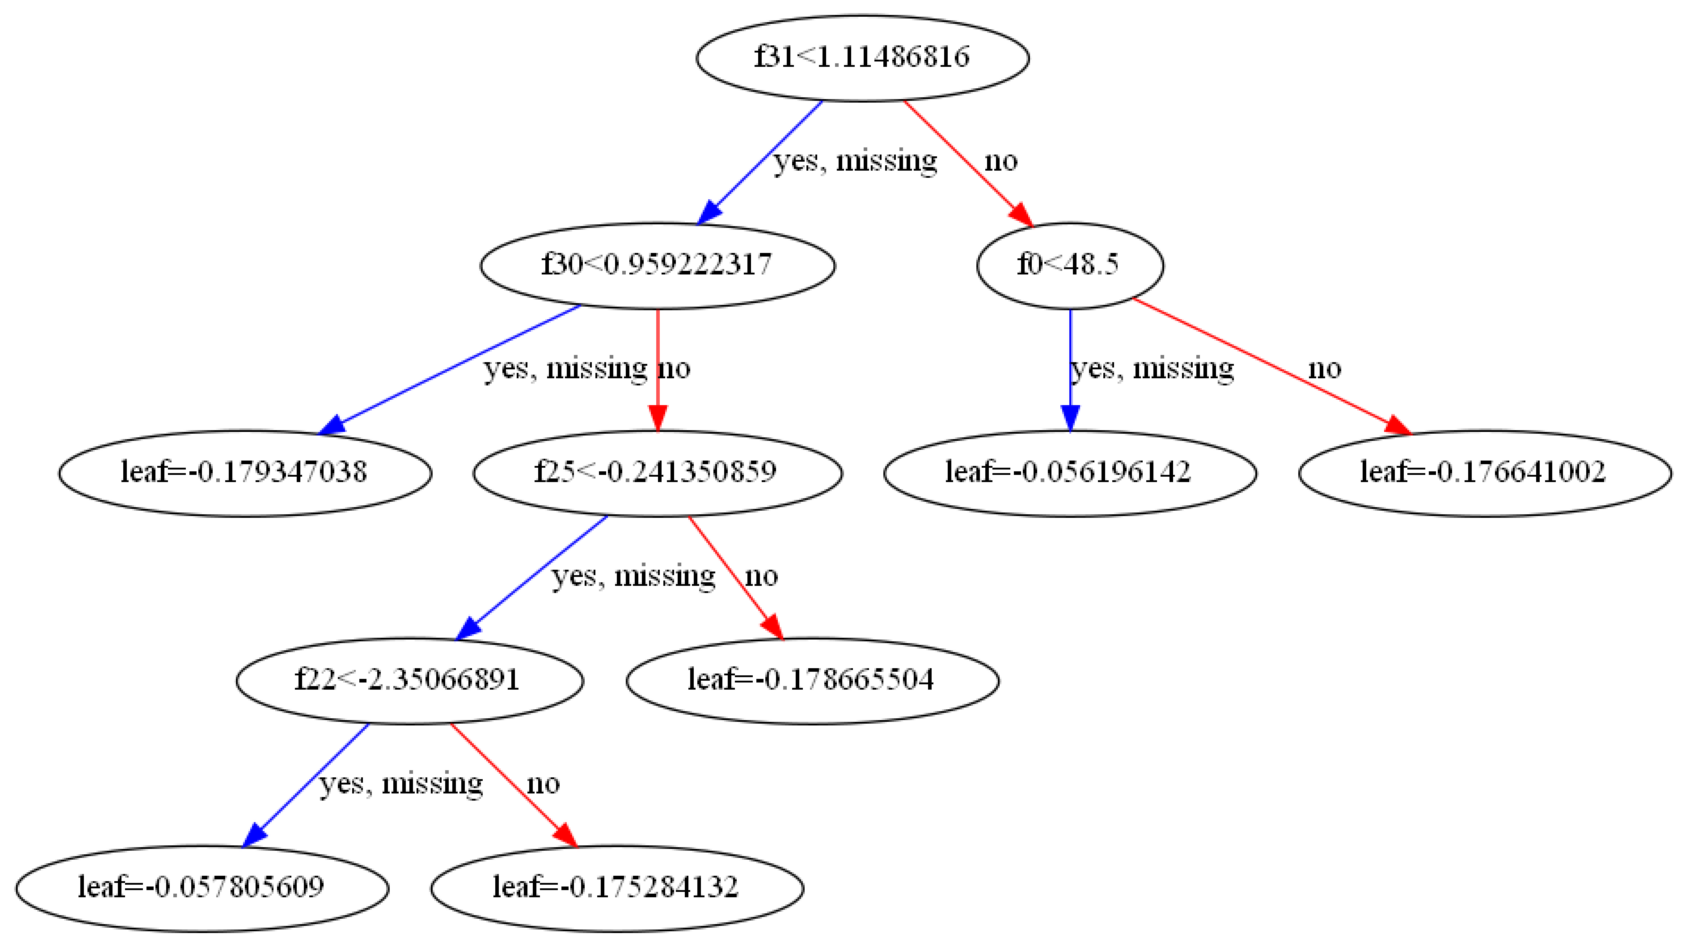

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(bst, num_trees=1, ax=ax)
plt.show()
# 图中可见, 特征出现缺失值时,判断路径 都是左子树

###### 稀疏感知

指定缺失值为 '-1', xgboost将自动采用稀疏感知划分子节点

In [66]:
%%time 

import  xgboost as xgb 


param = {
    
    'seed': 0,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'max_depth': 8,
    
}

param['eval_metric'] = 'auc'

dtrain = xgb.DMatrix( X_train,label=y_train,missing=-1) # X_train 中 -1 代表 NaN
dtest = xgb.DMatrix(X_test, label=y_test,missing=-1)


watchlist = [(dtrain,'train')]

num_round = 50

bst2 = xgb.train( param ,dtrain  ,num_round, evals =watchlist )

# Wall time: 1min 18s

[0]	train-auc:0.57114
[1]	train-auc:0.57117
[2]	train-auc:0.58578
[3]	train-auc:0.58578
[4]	train-auc:0.60916
[5]	train-auc:0.61769
[6]	train-auc:0.61643
[7]	train-auc:0.62254
[8]	train-auc:0.62338
[9]	train-auc:0.62297
[10]	train-auc:0.62442
[11]	train-auc:0.62513
[12]	train-auc:0.62631
[13]	train-auc:0.62927
[14]	train-auc:0.63023
[15]	train-auc:0.63104
[16]	train-auc:0.63215
[17]	train-auc:0.63437
[18]	train-auc:0.63582
[19]	train-auc:0.63895
[20]	train-auc:0.64013
[21]	train-auc:0.64172
[22]	train-auc:0.64504
[23]	train-auc:0.64733
[24]	train-auc:0.64928
[25]	train-auc:0.65167
[26]	train-auc:0.65481
[27]	train-auc:0.65963
[28]	train-auc:0.66433
[29]	train-auc:0.66785
[30]	train-auc:0.67127
[31]	train-auc:0.67424
[32]	train-auc:0.67684
[33]	train-auc:0.68148
[34]	train-auc:0.68407
[35]	train-auc:0.68706
[36]	train-auc:0.69036
[37]	train-auc:0.69359
[38]	train-auc:0.69596
[39]	train-auc:0.69816
[40]	train-auc:0.70219
[41]	train-auc:0.70645
[42]	train-auc:0.70945
[43]	train-auc:0.7133

<AxesSubplot:>

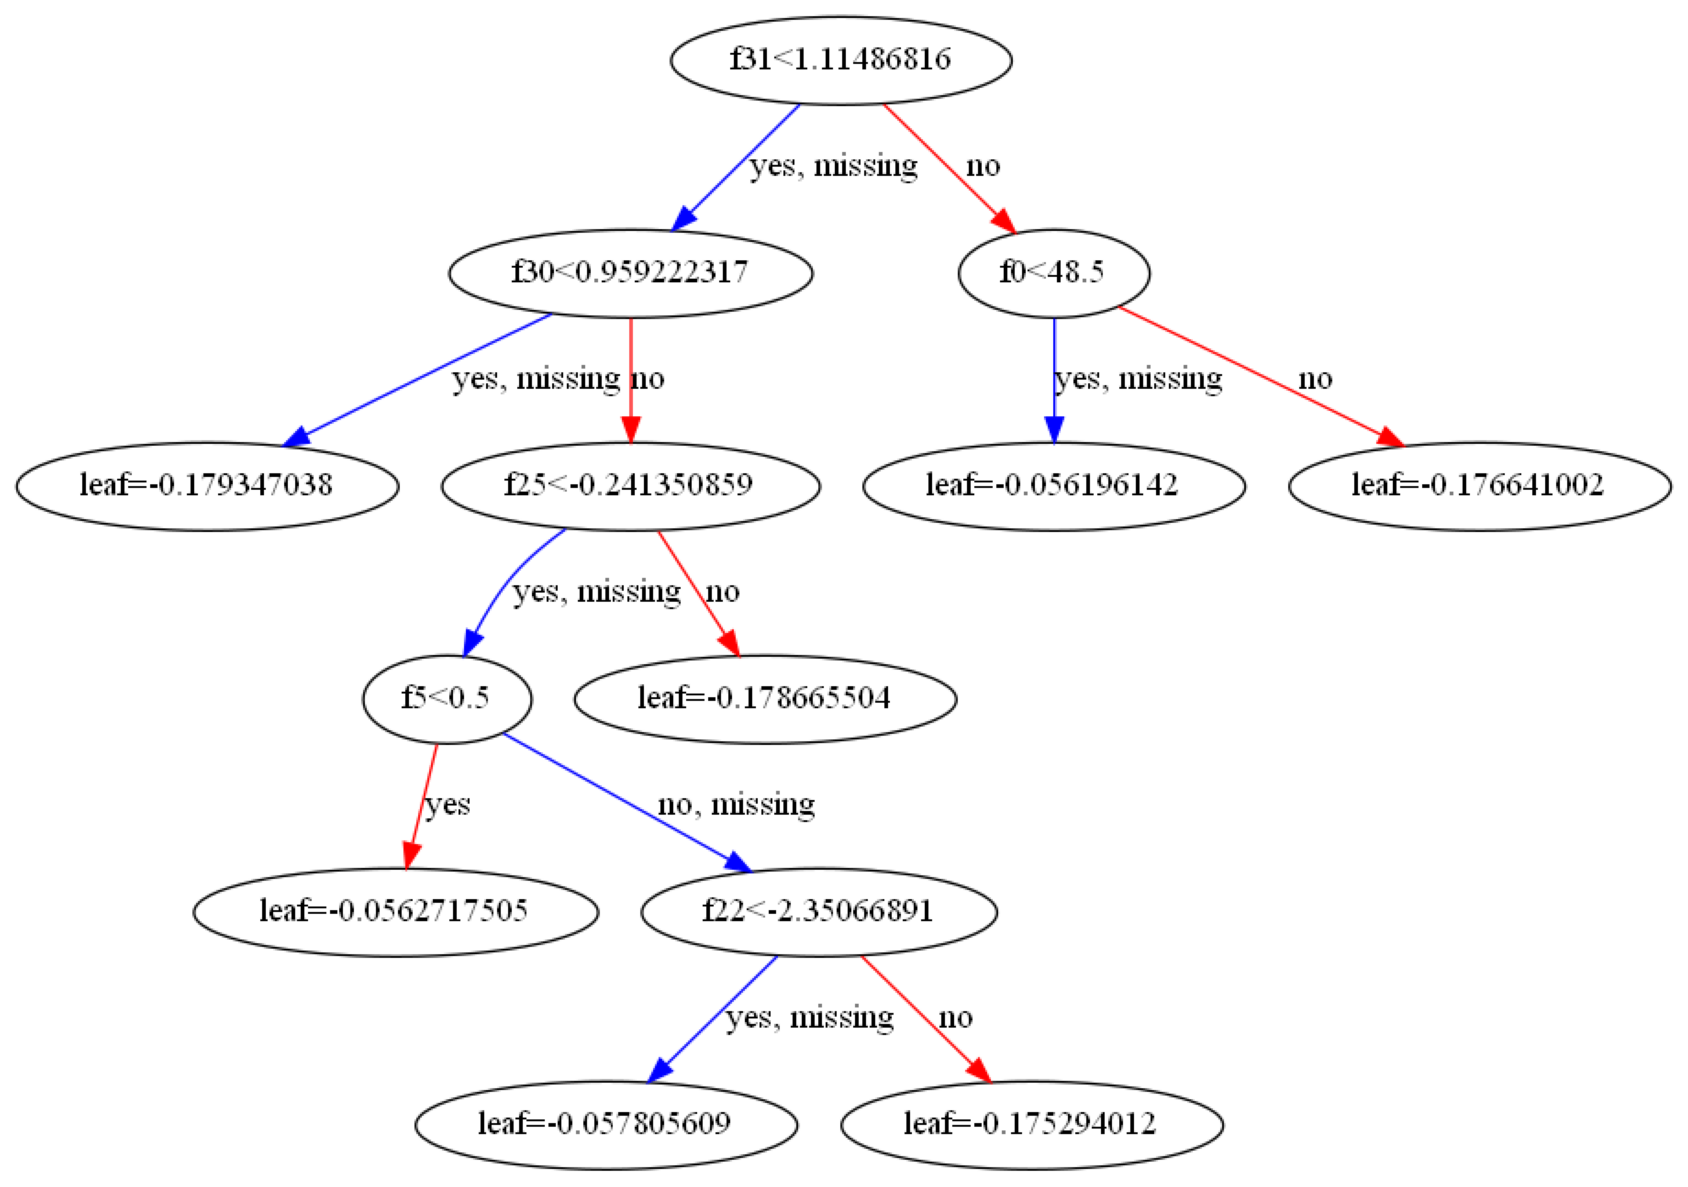

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(bst2, num_trees=1, ax=ax)
plt.show()
# 图中标出了 特征出现缺失值时 的判断路径 ( yes,missing  ; no,missing )

In [59]:
from  sklearn.metrics import roc_auc_score, accuracy_score


preds=bst.predict(dtest)

ypred = preds.copy()
ypred[preds > 0.5] = 1
ypred[ypred != 1] = 0

print("Accuracy:{}".format(accuracy_score(y_test,ypred)))

print("AUC:{}".format(roc_auc_score(y_test,preds)))


Accuracy:0.99209
AUC:0.6176724021650956


In [47]:
# 看一下 自带的测试数据集

testing_data = pd.read_csv(Allstate_dataset_path+'/test_set.csv',nrows =100000)
testing_data

#  测试数据没有  Claim_Amount 列

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4
0,13184291,11885,1,2008,2001,P,P.24,P.24.0,A,C,B,A,A,D,C,B,A,A,A,B,5,0.258125,1.777519,-0.013495,1.669468,0.330938,0.430648,-0.886198,3.461982,N,-0.23153,-0.266117,2.715490,-0.251419
1,13184292,11885,1,2009,2001,P,P.24,P.24.0,A,C,B,A,A,D,C,B,A,B,A,D,5,0.258125,1.777519,-0.013495,1.669468,0.330938,0.430648,-0.886198,3.461982,M,-0.23153,-0.266117,-0.272337,-0.251419
2,13184293,11887,1,2008,2003,Y,Y.29,Y.29.0,B,C,A,A,A,D,C,B,B,B,A,C,4,-0.119519,-0.124506,0.217908,-0.191039,0.527193,-0.231408,-0.665021,-0.131601,O,-0.23153,-0.266117,-0.272337,-0.251419
3,13184294,11887,1,2009,2003,Y,Y.29,Y.29.0,B,C,A,A,A,D,C,B,B,A,A,B,4,-0.119519,-0.124506,0.217908,-0.191039,0.527193,-0.231408,-0.665021,-0.131601,O,-0.23153,-0.266117,-0.272337,-0.251419
4,13184295,11888,1,2008,2006,AU,AU.14,AU.14.1,B,A,B,A,A,B,C,A,B,B,A,C,2,-0.143623,-0.297418,-0.383740,-0.275608,0.069263,-0.685256,-0.591295,-0.163872,O,-0.23153,-0.266117,-0.272337,-0.251419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,13284286,142692,1,2008,2000,BV,BV.8,BV.8.1,B,C,A,A,A,B,C,B,B,A,B,C,4,-0.400743,-0.297418,-0.453161,-0.191039,-0.263777,-0.652504,-1.009074,-0.644657,L,3.19779,-0.266117,-0.272337,3.068692
99996,13284287,142692,1,2009,2000,BV,BV.8,BV.8.1,B,C,A,A,A,B,C,B,B,A,E,C,4,-0.400743,-0.297418,-0.453161,-0.191039,-0.263777,-0.652504,-1.009074,-0.644657,L,3.19779,-0.266117,-0.272337,3.068692
99997,13284288,142696,1,2008,2002,AF,AF.24,AF.24.1,A,C,B,A,A,B,C,A,A,B,F,C,4,-0.424848,0.117570,-0.383740,0.045752,-0.430297,-0.185790,-0.972211,0.980933,O,-0.23153,-0.266117,-0.272337,-0.251419
99998,13284289,142696,1,2009,2002,AF,AF.24,AF.24.1,A,C,B,A,A,B,C,A,A,A,B,D,4,-0.424848,0.117570,-0.383740,0.045752,-0.430297,-0.185790,-0.972211,0.980933,O,-0.23153,-0.266117,-0.272337,-0.251419


In [57]:
%%time

USE_PRETRAINED=False 

if USE_PRETRAINED: 
    with open('pretrained/xgb_bst_cv1.pkl', 'rb') as f:
        bst_cv1 = pickle.load(f)
        
else:
    bst_cv1 = xgb.cv(param, dtrain, num_boost_round=50, nfold=3, seed=0)

bst_cv1 

#忽略稀疏值   Wall time: 2min 25s
# 稀疏感知     Wall time: 2min 43s

Wall time: 2min 43s


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.569137,0.001830,0.568336,0.007943
1,0.579621,0.012879,0.577949,0.011650
2,0.589123,0.010646,0.587987,0.018480
3,0.589491,0.010119,0.588124,0.018290
4,0.589384,0.010036,0.588400,0.018352
5,0.606058,0.002505,0.601491,0.011221
6,0.610390,0.005036,0.604177,0.008987
7,0.611801,0.004140,0.605066,0.009433
8,0.616400,0.007219,0.608514,0.006711
9,0.616822,0.006735,0.608172,0.006084


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

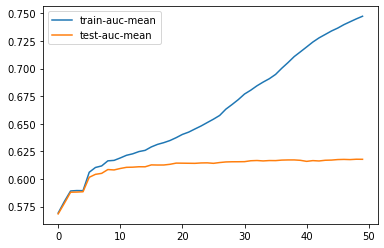

In [58]:
import matplotlib.pyplot as plt

plt.figure()
bst_cv1[['train-auc-mean', 'test-auc-mean']].plot()

# 我的 xgboost

In [ ]:
idx=np.array(range(3)).reshape(-1, 1)
f=np.array([6,5,4]).reshape(-1, 1)

f
idx

f_idx=np.concatenate([f,idx],axis=1)

f_idx

# np.sort(f_idx,axis=0 )
# np.sort(f_idx,axis=1 )

f_idx = f_idx[f_idx[:,0].argsort()] # 按照第0列 对行排序
f_idx

In [ ]:
f_idx[:1+1,:]
f_idx[1+1:,:]

In [ ]:
f_idx[:2+1,:]
f_idx[2+1:,:]

In [ ]:
left=f_idx[:1+1,:]
right=f_idx[1+1:,:]

index_left=left[:,1]
index_left

In [ ]:
block_k=np.array([[10, 0],
                  [11, 1],
                  [12, 2]])

# block_k[:,1]==[1,2]

# block_k[:,1]==[0,1,2]

# block_k[ block_k[:,1]==[0,1,2] , : ]


In [ ]:
condition= np.array([ True if sample_id in set(index_left) else False for sample_id in block_k[:,1]  ] )

condition

In [ ]:
block_k[ condition , : ]

In [ ]:
condition_not= ~condition
block_k[ condition_not , : ]